## Import Libraries

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, GlobalAveragePooling2D, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, Activation, Dropout,UpSampling2D ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [22]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [23]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [4]:
# with open('../data/no_deskew_data.npy', 'rb') as f:
#     X_trains = np.load(f)
#     X_letter = np.load(f)
#     y_trains = np.load(f)
#     TEST = np.load(f)
#     TEST_letter = np.load(f)

In [8]:
with open('../data/auto_data.npy', 'rb') as f:
    train_auto = np.load(f)
    y_auto = np.load(f)
    test_auto = np.load(f)


In [47]:
with open('../data/auto10000_data.npy', 'rb') as f:
    train_auto = np.load(f)
    y_auto = np.load(f)
    test_auto = np.load(f)



In [67]:
with open('../data/auto10000_deskew_data.npy', 'rb') as f:
    train_auto = np.load(f)
    y_auto = np.load(f)
    test_auto = np.load(f)



In [5]:
with open('../data/auto3_new_data.npy', 'rb') as f:
    train_auto = np.load(f)
    y_auto = np.load(f)
    test_auto = np.load(f)


In [5]:
with open('../data/noise0_data.npy', 'rb') as f:
    train_auto = np.load(f)
    y_auto = np.load(f)
    test_auto = np.load(f)


In [24]:
with open('../data/noise0_gen_data.npy', 'rb') as f:
    train_auto = np.load(f)
    y_auto = np.load(f)
    test_auto = np.load(f)


In [38]:
with open('../data/noise0_deskew_data.npy', 'rb') as f:
    train_auto = np.load(f)
    y_auto = np.load(f)
    test_auto = np.load(f)


In [39]:
print(train_auto.shape)
print(y_auto.shape)
print(test_auto.shape)


(10240, 28, 28, 1)
(10240, 10)
(20480, 28, 28, 1)


In [40]:
# X_trains = X_trains.astype('float32')
# X_letter = X_letter.astype('float32')
# TEST_letter = TEST_letter.astype('float32')
# TEST = TEST.astype('float32')

In [41]:
# X_trains = X_trains/255.
# TEST = TEST/255.

### Your Model

주석 처리된 것처럼 함수형태로 만들어야 합니다.

### RexNet

In [42]:
reduction_ratio=16

def rexnet_model(shape):
    inputs = Input(shape=(28,28,1))
#     letter = Input(shape=(26))
    
#     letter_dense1 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(letter)
#     batchs = tf.keras.layers.BatchNormalization()(letter_dense1)
#     letter_dense2 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(batchs)

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) 
    
    flatten1 = tf.keras.layers.Flatten()(pool7)
#     gmp = tf.keras.layers.GlobalAveragePooling2D()(pool7)
#     con = tf.keras.layers.concatenate([gmp, letter_dense2],axis=1)
    
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

### DenseNet

In [43]:
layers_in_block = {'DenseNet-121':[6, 12, 24, 16],
                   'DenseNet-169':[6, 12, 32, 32],
                   'DenseNet-201':[6, 12, 48, 32],
                   'DenseNet-265':[6, 12, 64, 48],
                   'myDenseNet':[8, 12, 16, 32]}

base_growth_rate = 32

def Conv_block(x, growth_rate, activation='relu'):
    x_l = BatchNormalization()(x)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate*4, (1,1), padding='same', kernel_initializer='he_normal')(x_l)
    
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate, (3,3), padding='same', kernel_initializer='he_normal')(x_l)
    
    x = concatenate([x, x_l])
    return x

def Dense_block(x, layers, growth_rate=32):
    for i in range(layers):
        x = Conv_block(x, growth_rate)
    return x

def Transition_layer(x, compression_factor=0.5, activation='relu'):
    reduced_filters = int(tf.keras.backend.int_shape(x)[-1] * compression_factor)
    
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(reduced_filters, (1,1), padding='same', kernel_initializer='he_normal')(x)
    
    x = AveragePooling2D((2,2), padding='same', strides=2)(x)
    return x

#### DenseNet-121

In [44]:
def DenseNet_121(shape, densenet_type='DenseNet-121'):
    model_input = Input(shape=(28,28,1))
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
    #x = Transition_layer(x, compression_factor=0.5)
    #x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = GlobalAveragePooling2D()(x)
    
    model_output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(model_input, model_output)
    
    return model

#### DenseNet-169

In [45]:
def DenseNet_169(shape, densenet_type='DenseNet-169'):
    model_input = Input(shape=(28,28,1))
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
    #x = Transition_layer(x, compression_factor=0.5)
    #x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = GlobalAveragePooling2D()(x)
    
    model_output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(model_input, model_output)
    
    return model

#### DenseNet-201

In [46]:
def DenseNet_201(shape, densenet_type='DenseNet-201'):
    model_input = Input(shape=(28,28,1))
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
    #x = Transition_layer(x, compression_factor=0.5)
    #x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = GlobalAveragePooling2D()(x)
    
    model_output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(model_input, model_output)
    
    return model

#### DenseNet-265

In [47]:
def DenseNet_265(shape, densenet_type='DenseNet-265'):
    model_input = Input(shape=(28,28,1))
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
    #x = Transition_layer(x, compression_factor=0.5)
    #x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = GlobalAveragePooling2D()(x)
    
    model_output = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(model_input, model_output)
    
    return model

In [48]:
def get_stacking(in_model, model_name, train, train_y, n_fold = 4, SEED=2020, epochs = 500, batch_size = 32, lr_=0.001, es_p = 100, rlp_p = 30, rlp_f = 0.7):
    k_fold = KFold(n_splits=n_fold, shuffle=True, random_state=SEED)
    
    history = []
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=lr_, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=es_p, verbose=1,monitor = 'val_accuracy')
        mc = ModelCheckpoint(f'../model/{in_model}_{model_name}_best_{cnt+1}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=rlp_p, factor=rlp_f, min_lr=0.000001)
        
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_val, y_val),
                            verbose=1,
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            validation_steps=x_val.shape[0] // batch_size,
                            callbacks=[es, mc, rlp]
                            )
        
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        print("load model and predict")
        model.load_weights(f'../model/{in_model}_{model_name}_best_{cnt+1}.h5')
        print("valid acc")
        x_val_acc = model.evaluate(x_val, y_val)
        print("\n\n\n")
        pred_train = model.predict(x_val)
        pred_test = model.predict(test_auto)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((test_auto.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

### RexNet

In [49]:
epochs = 15
batch_size = 32
n_fold = 4
seed = 2020
model_name = "auto_deskew_RexNet0.7" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 5 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=3 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

*******************number_1_kfold_model*******************
Epoch 1/15
240/240 [==============================] - ETA: 0s - loss: 1.6891 - accuracy: 0.6685
Epoch 00001: val_loss improved from inf to 1.47009, saving model to ../model/<function rexnet_model at 0x7fdac86f6b00>_auto_deskew_RexNet0.7_best_1.h5
240/240 [==============================] - 10s 43ms/step - loss: 1.6891 - accuracy: 0.6685 - val_loss: 1.4701 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 2/15
239/240 [============================>.] - ETA: 0s - loss: 0.4944 - accuracy: 0.8647
Epoch 00002: val_loss improved from 1.47009 to 0.56850, saving model to ../model/<function rexnet_model at 0x7fdac86f6b00>_auto_deskew_RexNet0.7_best_1.h5
240/240 [==============================] - 9s 37ms/step - loss: 0.4991 - accuracy: 0.8642 - val_loss: 0.5685 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 3/15
239/240 [============================>.] - ETA: 0s - loss: 0.3835 - accuracy: 0.8950
Epoch 00003: val_loss did not improve from 0.56850
240/2

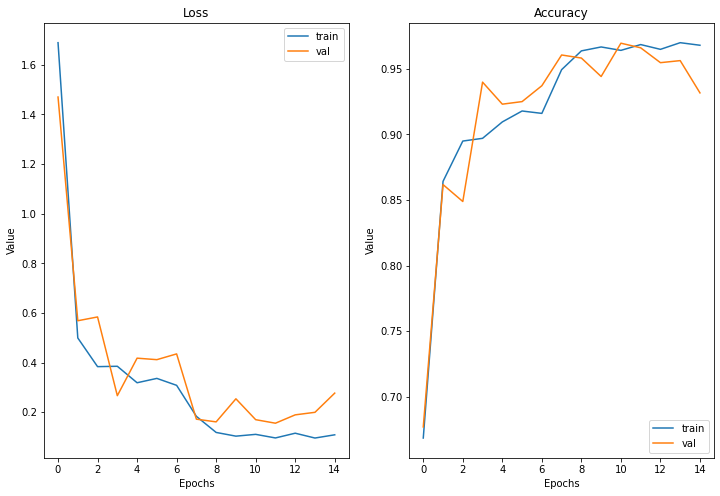

load model and predict
valid acc
80/80 [==============================] - 1s 9ms/step - loss: 0.1555 - accuracy: 0.9660




*******************number_2_kfold_model*******************
Epoch 1/15
239/240 [============================>.] - ETA: 0s - loss: 1.5388 - accuracy: 0.6740
Epoch 00001: val_loss improved from inf to 1.38202, saving model to ../model/<function rexnet_model at 0x7fdac86f6b00>_auto_deskew_RexNet0.7_best_2.h5
240/240 [==============================] - 8s 35ms/step - loss: 1.5345 - accuracy: 0.6749 - val_loss: 1.3820 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 2/15
239/240 [============================>.] - ETA: 0s - loss: 0.4779 - accuracy: 0.8742
Epoch 00002: val_loss improved from 1.38202 to 0.92931, saving model to ../model/<function rexnet_model at 0x7fdac86f6b00>_auto_deskew_RexNet0.7_best_2.h5
240/240 [==============================] - 8s 34ms/step - loss: 0.4809 - accuracy: 0.8737 - val_loss: 0.9293 - val_accuracy: 0.8105 - lr: 0.0010
Epoch 3/15
239/240 [=========

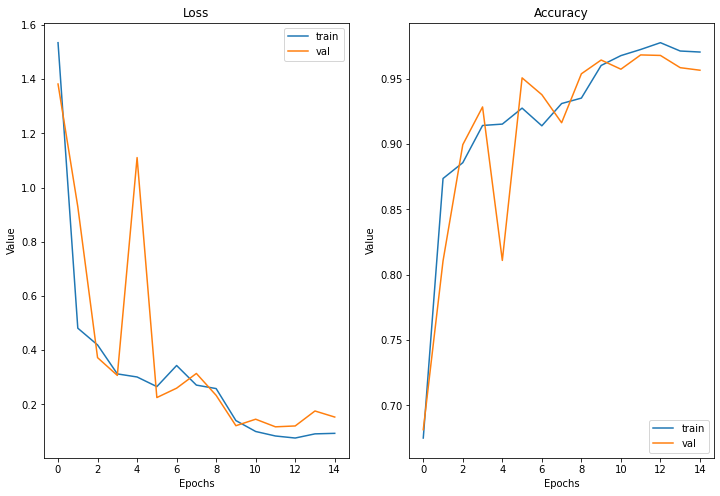

load model and predict
valid acc
80/80 [==============================] - 1s 9ms/step - loss: 0.1169 - accuracy: 0.9684




*******************number_3_kfold_model*******************
Epoch 1/15
239/240 [============================>.] - ETA: 0s - loss: 1.5315 - accuracy: 0.6772
Epoch 00001: val_loss improved from inf to 2.70410, saving model to ../model/<function rexnet_model at 0x7fdac86f6b00>_auto_deskew_RexNet0.7_best_3.h5
240/240 [==============================] - 10s 40ms/step - loss: 1.5280 - accuracy: 0.6775 - val_loss: 2.7041 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 2/15
239/240 [============================>.] - ETA: 0s - loss: 0.4963 - accuracy: 0.8655
Epoch 00002: val_loss improved from 2.70410 to 0.42675, saving model to ../model/<function rexnet_model at 0x7fdac86f6b00>_auto_deskew_RexNet0.7_best_3.h5
240/240 [==============================] - 9s 37ms/step - loss: 0.4945 - accuracy: 0.8658 - val_loss: 0.4267 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 3/15
239/240 [========

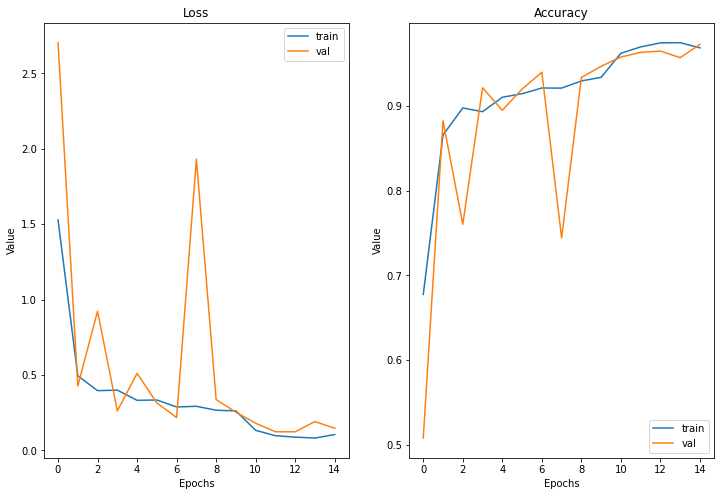

load model and predict
valid acc
80/80 [==============================] - 1s 9ms/step - loss: 0.1227 - accuracy: 0.9648




*******************number_4_kfold_model*******************
Epoch 1/15
239/240 [============================>.] - ETA: 0s - loss: 1.6528 - accuracy: 0.6628
Epoch 00001: val_loss improved from inf to 3.05978, saving model to ../model/<function rexnet_model at 0x7fdac86f6b00>_auto_deskew_RexNet0.7_best_4.h5
240/240 [==============================] - 9s 37ms/step - loss: 1.6500 - accuracy: 0.6634 - val_loss: 3.0598 - val_accuracy: 0.4934 - lr: 0.0010
Epoch 2/15
239/240 [============================>.] - ETA: 0s - loss: 0.4990 - accuracy: 0.8632
Epoch 00002: val_loss improved from 3.05978 to 1.01701, saving model to ../model/<function rexnet_model at 0x7fdac86f6b00>_auto_deskew_RexNet0.7_best_4.h5
240/240 [==============================] - 9s 36ms/step - loss: 0.4971 - accuracy: 0.8638 - val_loss: 1.0170 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 3/15
239/240 [=========

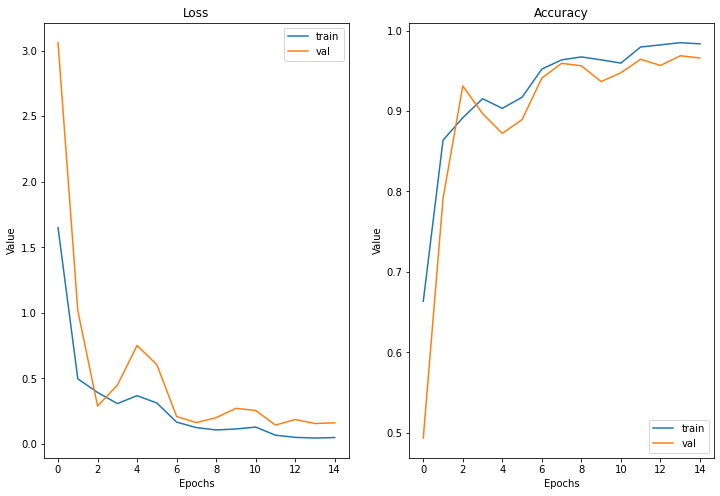

load model and predict
valid acc
80/80 [==============================] - 1s 9ms/step - loss: 0.1447 - accuracy: 0.9645






In [50]:
model_train, model_test = get_stacking(rexnet_model, model_name, train_auto, y_auto, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

In [51]:
pickle.dump(model_train, open("../new_data/{}.pkl".format("auto_noise0_deskew"), "wb"))
pickle.dump(model_test, open("../new_data/{}.pkl".format("auto_noise0_deskew"), "wb"))

### DenseNet-121

In [37]:
epochs = 40
batch_size = 32
n_fold = 4
seed = 2020
model_name = "auto_Dexnet121" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 15 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=5 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

*******************number_1_kfold_model*******************
Epoch 1/40
480/480 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.7969
Epoch 00001: val_loss improved from inf to 0.98311, saving model to ../model/<function DenseNet_121 at 0x7fe35ab9ae60>_auto_Dexnet121_best_1.h5
480/480 [==============================] - 45s 93ms/step - loss: 0.6908 - accuracy: 0.7969 - val_loss: 0.9831 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 2/40
480/480 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8794
Epoch 00002: val_loss did not improve from 0.98311
480/480 [==============================] - 44s 92ms/step - loss: 0.3745 - accuracy: 0.8794 - val_loss: 2.8679 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 3/40
480/480 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8927
Epoch 00003: val_loss improved from 0.98311 to 0.73885, saving model to ../model/<function DenseNet_121 at 0x7fe35ab9ae60>_auto_Dexnet121_best_1.h5
480/480 [=========

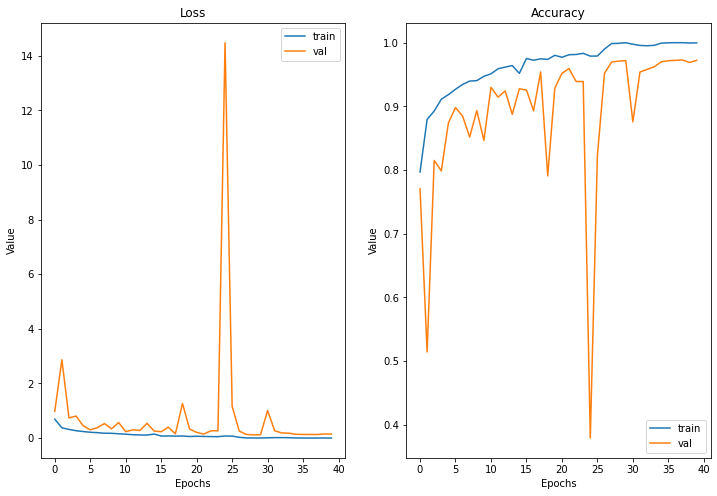

load model and predict
valid acc
160/160 [==============================] - 3s 17ms/step - loss: 0.1174 - accuracy: 0.9711




*******************number_2_kfold_model*******************
Epoch 1/40
480/480 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.7888
Epoch 00001: val_loss improved from inf to 0.89978, saving model to ../model/<function DenseNet_121 at 0x7fe35ab9ae60>_auto_Dexnet121_best_2.h5
480/480 [==============================] - 35s 72ms/step - loss: 0.7096 - accuracy: 0.7888 - val_loss: 0.8998 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 2/40
480/480 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8735
Epoch 00002: val_loss did not improve from 0.89978
480/480 [==============================] - 33s 69ms/step - loss: 0.3884 - accuracy: 0.8735 - val_loss: 1.2181 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 3/40
480/480 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8935
Epoch 00003: val_loss improved from 0.8

480/480 [==============================] - 44s 92ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.1408 - val_accuracy: 0.9629 - lr: 5.0000e-04
Epoch 26/40
480/480 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9980
Epoch 00026: val_loss improved from 0.14076 to 0.12476, saving model to ../model/<function DenseNet_121 at 0x7fe35ab9ae60>_auto_Dexnet121_best_2.h5
480/480 [==============================] - 44s 92ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.1248 - val_accuracy: 0.9674 - lr: 5.0000e-04
Epoch 27/40
480/480 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9951
Epoch 00027: val_loss did not improve from 0.12476
480/480 [==============================] - 44s 91ms/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.3811 - val_accuracy: 0.9334 - lr: 5.0000e-04
Epoch 28/40
480/480 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9937
Epoch 00028: val_loss improved from 0.12476 to 0.11357, savi

KeyboardInterrupt: 

In [43]:
model121_train, model121_test = get_stacking(DenseNet_121, model_name, train_auto, y_auto, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

### DenseNet-169

In [ ]:
epochs = 40
batch_size = 32
n_fold = 4
seed = 2020
model_name = "Dexnet169" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 15 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=5 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

In [ ]:
model169_train, model169_test = get_stacking(DenseNet_169, model_name, train_auto, y_auto, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

### DenseNet-201

In [ ]:
epochs = 200
batch_size = 32
n_fold = 4
seed = 2020
model_name = "Dexnet201" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 15 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=5 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

In [ ]:
model201_train, model201_test = get_stacking(DenseNet_201, model_name, train_auto, y_auto, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

### DenseNet-265

In [ ]:
epochs = 200
batch_size = 32
n_fold = 4
seed = 2020
model_name = "Dexnet265" #저장할 모델이름
learning_rate = 0.001
EarlyStopping_patience = 15 # 얼마나 지켜보고 early stopping 할것인가
ReduceLROnPlateau_patience=5 # 얼마나 지켜보고 learing rate 감소시킬 것인가
ReduceLROnPlateau_factor=0.5 # 감소시키는 비율 learing rate := learing rate * factor

In [ ]:
model265_train, model265_test = get_stacking(DenseNet_265, model_name, train_auto, y_auto, n_fold, seed, epochs, batch_size, learning_rate, EarlyStopping_patience, ReduceLROnPlateau_patience, ReduceLROnPlateau_factor)

## Pickle 파일 저장

format안에 이름을 설정해주세요  
e.g.  
rx_train_jh  
rx_test_jh  

### RexNet

In [25]:
# pickle.dump(model_train, open("../new_data/{}.pkl".format("rx_train_jh"), "wb"))
# pickle.dump(model_test, open("../new_data/{}.pkl".format("rx_test_jh"), "wb"))

### DenseNet

In [38]:
pickle.dump(model121_train, open("../new_data/{}.pkl".format("auto_ds121_train_jh"), "wb"))
pickle.dump(model121_test, open("../new_data/{}.pkl".format("auto_ds121_test_jh"), "wb"))

In [ ]:
pickle.dump(model169_train, open("../new_data/{}.pkl".format("auto_ds169_train_jh"), "wb"))
pickle.dump(model169_test, open("../new_data/{}.pkl".format("auto_ds169_test_jh"), "wb"))

In [ ]:
pickle.dump(model201_train, open("../new_data/{}.pkl".format("auto_ds201_train_jh"), "wb"))
pickle.dump(model201_test, open("../new_data/{}.pkl".format("auto_ds201_test_jh"), "wb"))

In [ ]:
pickle.dump(model265_train, open("../new_data/{}.pkl".format("auto_ds265_train_jh"), "wb"))
pickle.dump(model265_test, open("../new_data/{}.pkl".format("auto_ds265_test_jh"), "wb"))